### Statistical Learning Approach

ARIMA

In [1]:
!pip install --upgrade --no-deps statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.1)


In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [17]:
plt.rcParams['figure.figsize'] = [10, 7.5]

Import data

In [ ]:
data = pd.read_csv('jj.csv')

In [ ]:
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


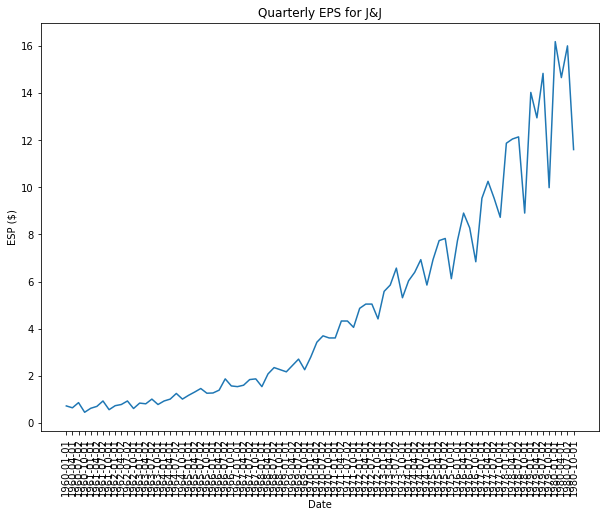

In [ ]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for J&J')
plt.ylabel('ESP ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

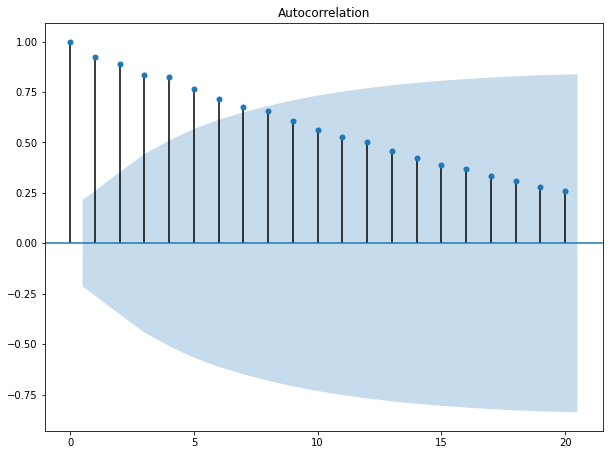

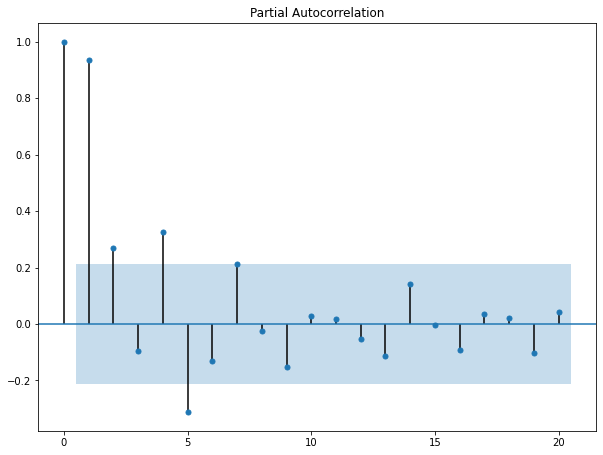

In [ ]:
plot_acf(data['data']);
plot_pacf(data['data']);

In [ ]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

In [ ]:
data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


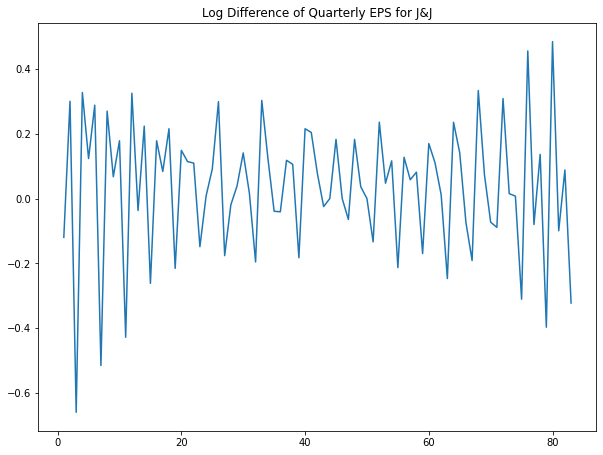

In [ ]:
plt.plot(data['data_tr_1'])
plt.title('Log Difference of Quarterly EPS for J&J')
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data_tr_1'][1:])

In [ ]:
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Critical Values: ')
for key, value in ad_fuller_result[4].items():
    print(f'\t{key} {value:.3f}')

ADF Statistic: -4.317043945811838
p-value: 0.00041497314044406503
Critical Values: 
	1% -3.518
	5% -2.900
	10% -2.587


- 검정통계량(ADF Statistics)가 Critical Value보다 작으면 stationary 한 시계열
- 혹은 P-value가 설정한 신뢰수준 값(예. 0.05)보다 작으면 stationary 한 시계열

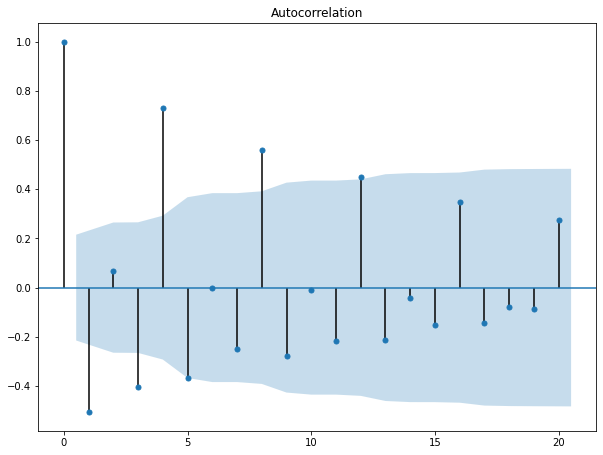

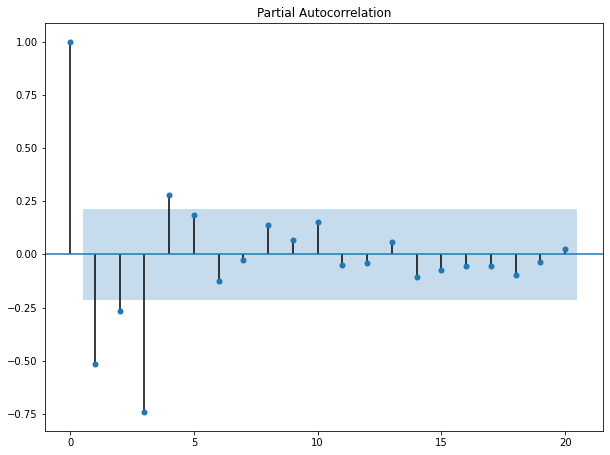

In [ ]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);

In [ ]:
def optimize_ARIMA(endog, order_list):
    '''
    Returns a data frame with parameters and corresponding AIC
    
    order_list - list with (p,d,q) tuples
    endog - the observed variable
    '''

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

"AIC : Akaike's Information Criterion  "
- 여러 통계모델의 성능을 서로 비교할수 있게 해줌.

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.543091
1,"(4, 1, 6)",115.859343
2,"(7, 1, 1)",116.055256
3,"(5, 1, 3)",116.535288
4,"(5, 1, 4)",117.243590
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [ ]:
best_model = SARIMAX(data['data'], order=(6, 1, 3), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.772
Date:                Mon, 01 Feb 2021   AIC                            115.543
Time:                        04:33:21   BIC                            139.731
Sample:                             0   HQIC                           125.261
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4445      0.120    -12.010      0.000      -1.680      -1.209
ar.L2         -0.7340      0.142     -5.165      0.000      -1.013      -0.455
ar.L3          0.0400      0.061      0.660      0.5

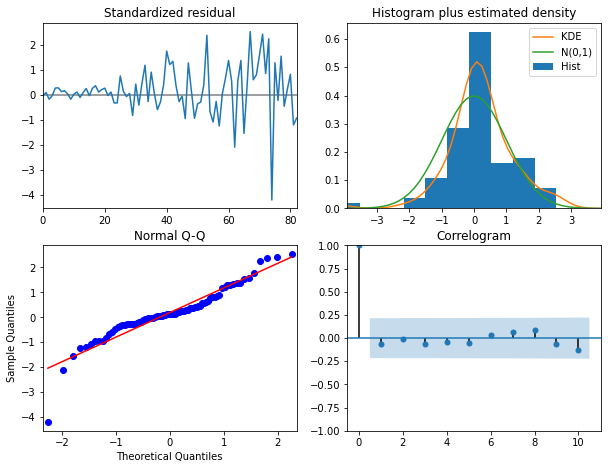

In [ ]:
res.plot_diagnostics();

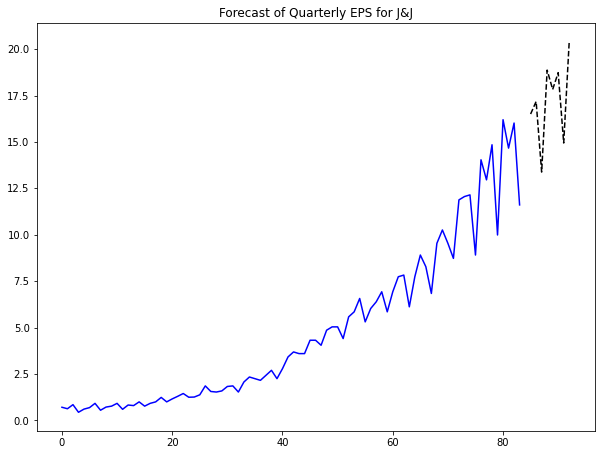

In [ ]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Quarterly EPS for J&J')
plt.show()

In [ ]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.679509
3,1960-10-01,0.44,-0.658462,0.720407
4,1961-01-01,0.61,0.326684,0.650420
5,1961-04-02,0.69,0.123233,0.528388
6,1961-07-02,0.92,0.287682,0.791281
7,1961-10-01,0.55,-0.514455,0.490412
8,1962-01-01,0.72,0.269333,0.646583
9,1962-04-02,0.77,0.067139,0.752586


In [ ]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE : {mse}')

MSE : 0.16100233513064993


SARIMA

In [ ]:
data = pd.read_csv('jj.csv')

In [ ]:
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


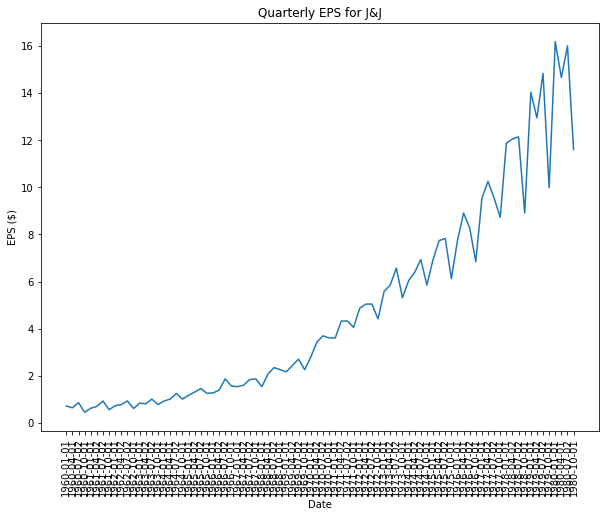

In [ ]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

In [ ]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

In [ ]:
data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


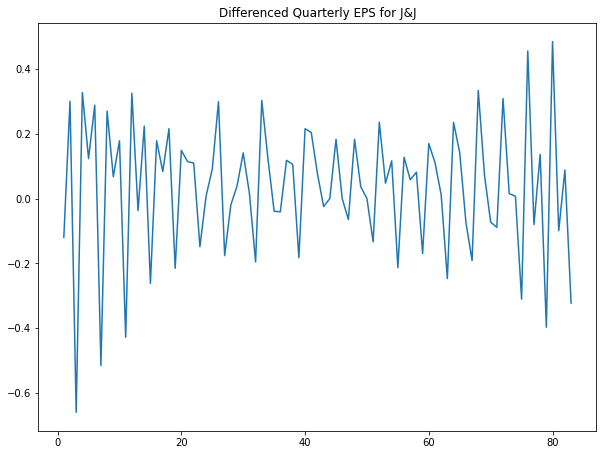

In [ ]:
plt.plot(data['data_tr_1'][1:])
plt.title('Differenced Quarterly EPS for J&J')
plt.show()

In [ ]:
data['data_tr_2'] = data['data_tr_1'][1:].diff(4)

In [ ]:
data.head(15)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


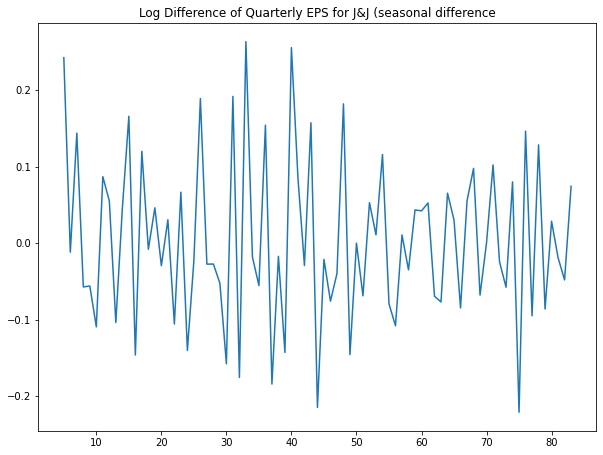

In [ ]:
plt.plot(data['data_tr_2'])
plt.title('Log Difference of Quarterly EPS for J&J (seasonal difference')
plt.show()

In [ ]:
ad_fuller_result = adfuller(data['data_tr_2'][5:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Critical Values: ')
for key, value in ad_fuller_result[4].items():
    print(f'\t{key} {value:.3f}')

ADF Statistic: -6.6308051099142675
p-value: 5.721578695136043e-09
Critical Values: 
	1% -3.523
	5% -2.902
	10% -2.588


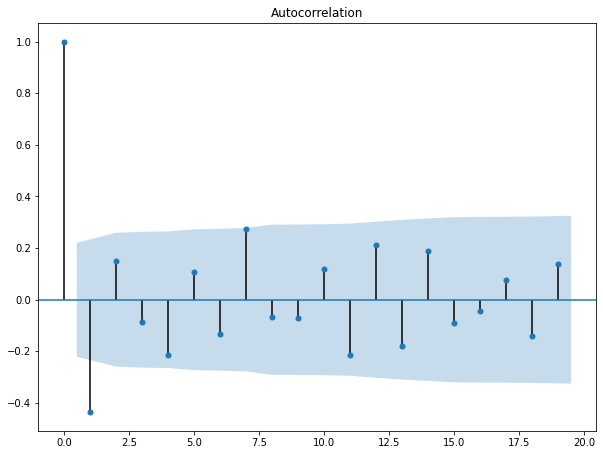

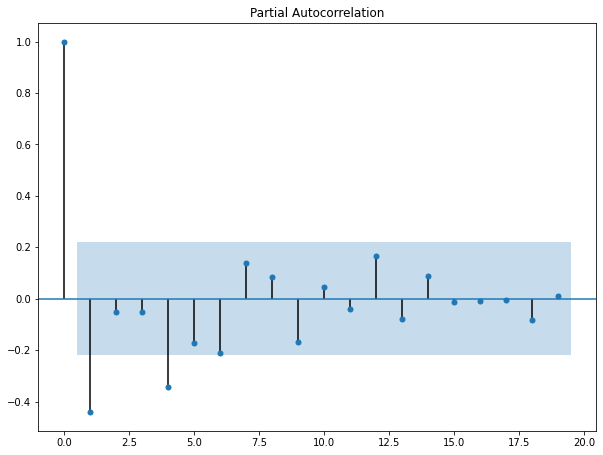

In [ ]:
plot_acf(data['data_tr_2'][5:]);
plot_pacf(data['data_tr_2'][5:]);

statsmodels 라이브러리에서의 endog(endogenous) / exog(exogenous)

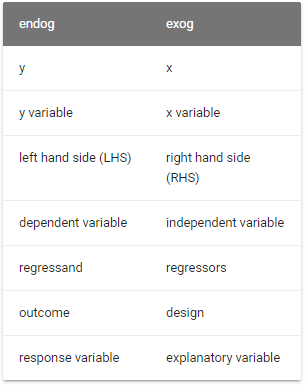

In [ ]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    '''
    Return dataframe with parameters and corresponding AIC

    endog - the observed variable
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order
    D - seasonal integration order
    s - length of a season
    '''

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog, 
                            order=(param[0], d, param[1]),
                            seasonal_order=(param[2], D, param[3], s), 
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [ ]:
result_df = optimize_SARIMA(data['data'], parameters_list, 1, 1, 4)
result_df

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 0)",92.587317
1,"(2, 3, 1, 0)",93.978055
2,"(2, 3, 0, 1)",94.131298
3,"(3, 2, 0, 3)",94.233369
4,"(3, 3, 0, 0)",94.475975
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086515
253,"(0, 0, 2, 3)",145.465206
254,"(0, 0, 3, 2)",145.563923


In [ ]:
best_model = SARIMAX(data['data'], order=(2,1,3), seasonal_order=(0,1,0,4), simple_differencing=False)
res = best_model.fit(disp=False)

print(res.summary())

                                 Statespace Model Results                                
Dep. Variable:                              data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 4)   Log Likelihood                 -40.294
Date:                           Mon, 01 Feb 2021   AIC                             92.587
Time:                                   05:49:36   BIC                            106.804
Sample:                                        0   HQIC                            98.283
                                            - 84                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4841      0.116    -12.818      0.000      -1.711      -1.257
ar.L2         -0.7896      0.131     -6.021

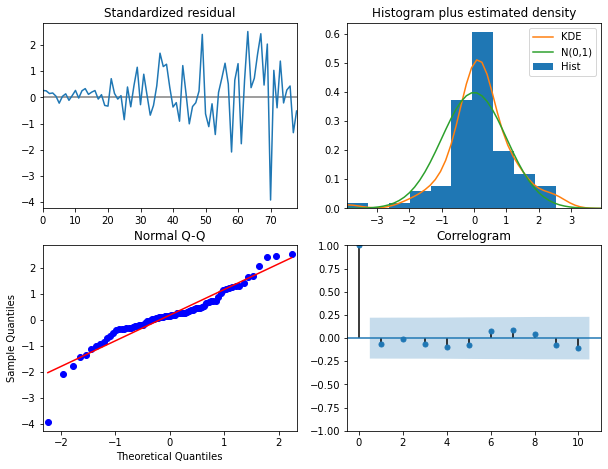

In [ ]:
res.plot_diagnostics();

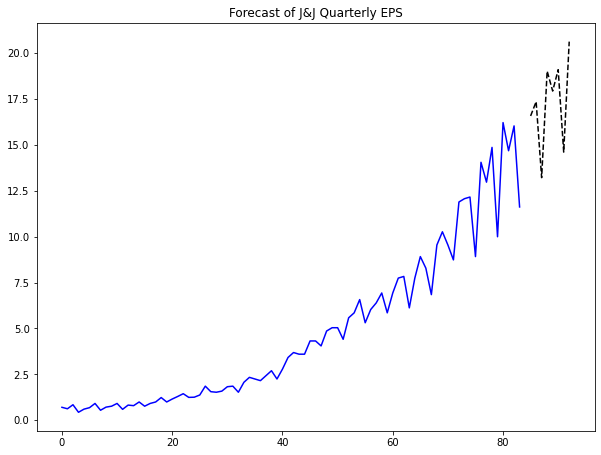

In [ ]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of J&J Quarterly EPS')
plt.show()

In [ ]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.804979
7,1961-10-01,0.55,-0.514455,0.144006,0.482740
8,1962-01-01,0.72,0.269333,-0.057351,0.645300
9,1962-04-02,0.77,0.067139,-0.056093,0.748660


In [ ]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.1561281916019696


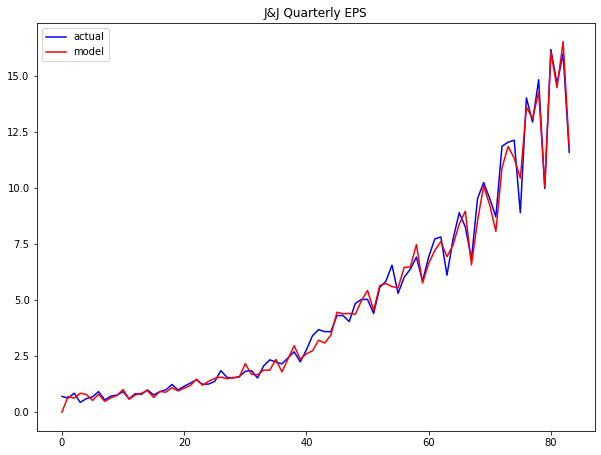

In [ ]:
plt.plot(data['data'], color='blue', label='actual')
plt.plot(data['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('J&J Quarterly EPS')
plt.show()

SARIMAX

In [ ]:
# United States Macroeconomic Dataset
macro_data = sm.datasets.macrodata.load_pandas()

In [ ]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [ ]:
macro_data = macro_data.data

In [ ]:
macro_data.shape

(203, 14)

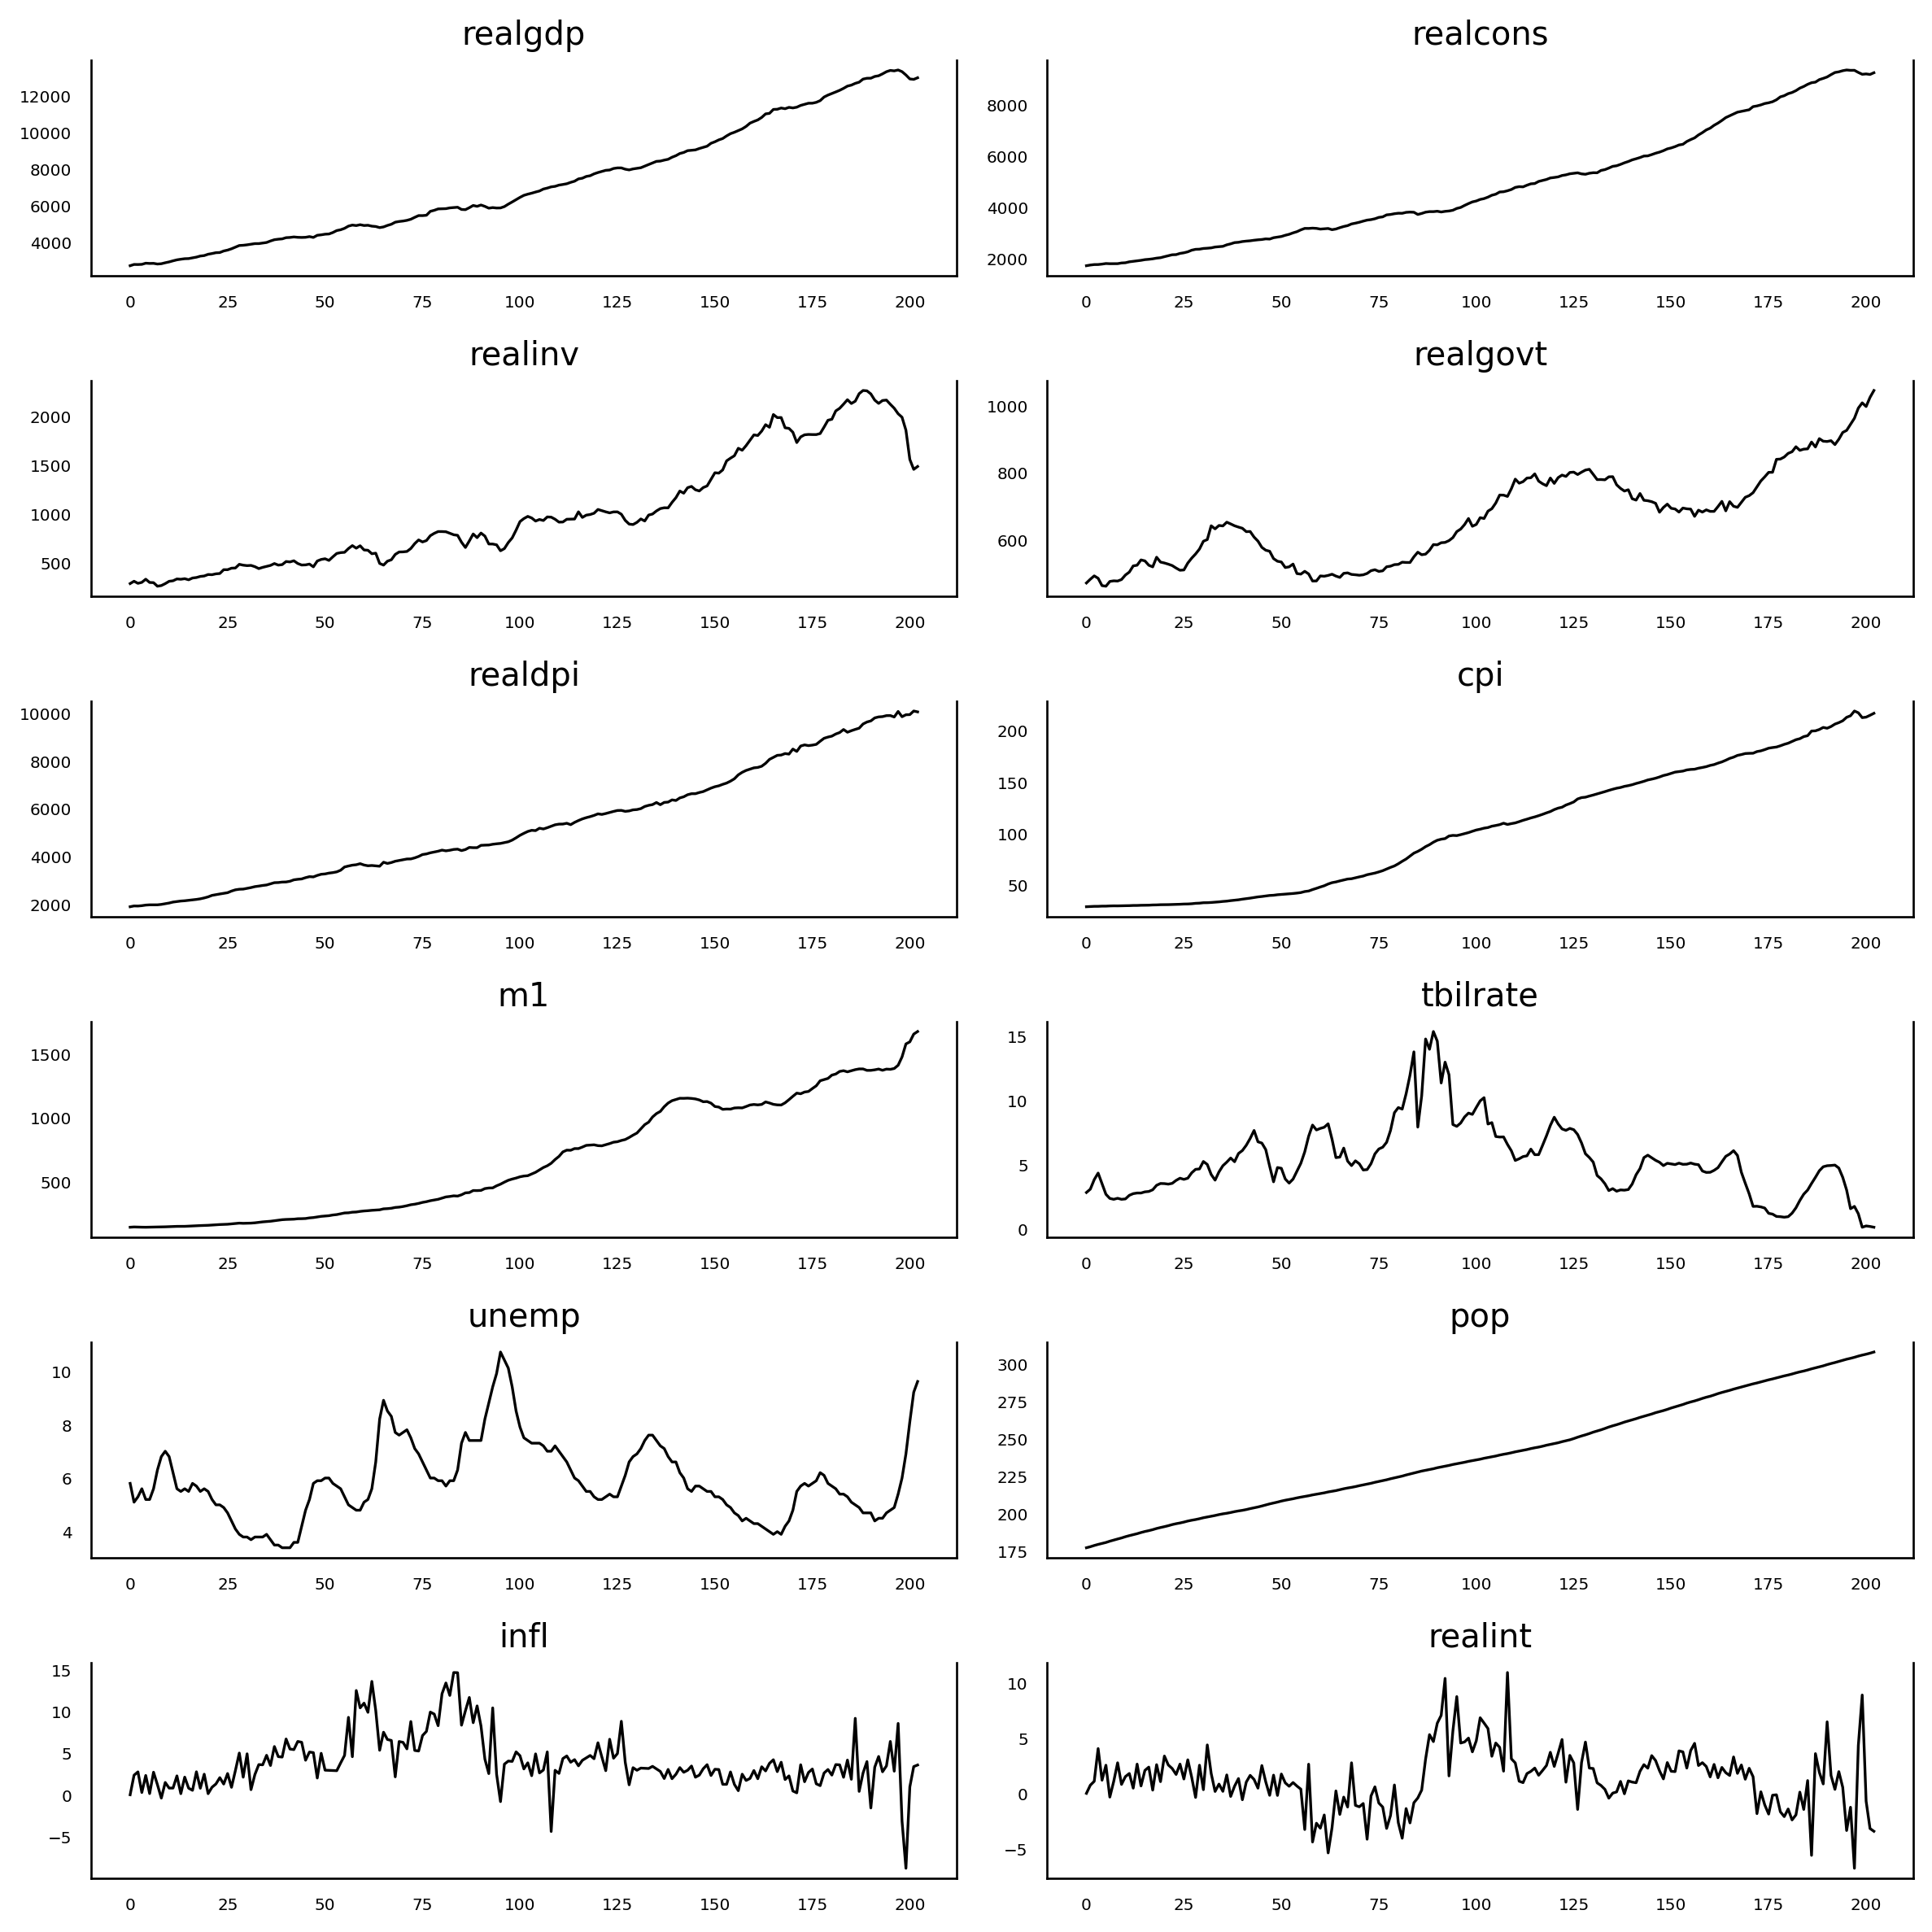

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=240, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
macro_data['realgdp_tr1'] = macro_data['realgdp'].diff()
macro_data.head(10)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55,-13.309
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34,4.632
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08,-36.406
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77,16.648
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81,52.741


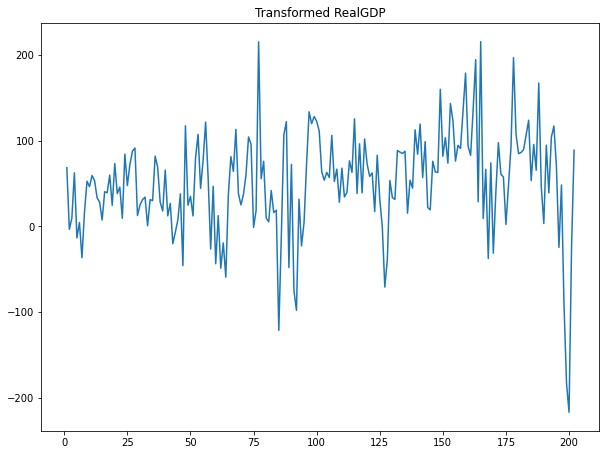

In [ ]:
plt.plot(macro_data['realgdp_tr1'])
plt.title('Transformed RealGDP')
plt.show()

In [ ]:
ad_fuller_result = adfuller(macro_data['realgdp_tr1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Critical Values: ')
for key, value in ad_fuller_result[4].items():
    print(f'\t{key} {value:.3f}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08
Critical Values: 
	1% -3.463
	5% -2.876
	10% -2.575


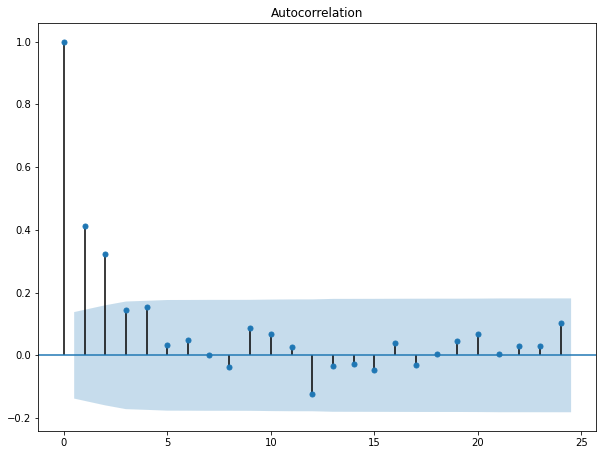

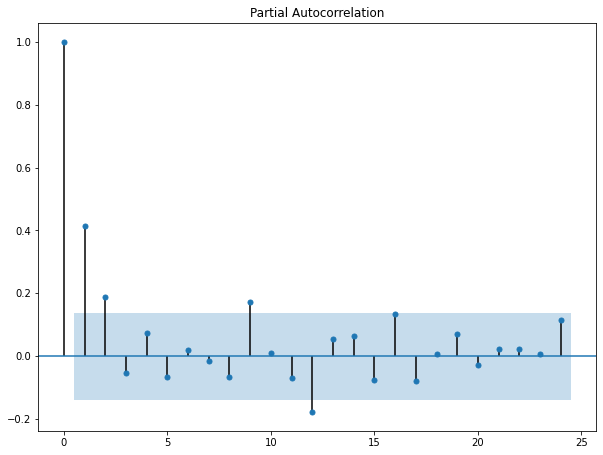

In [ ]:
plot_acf(macro_data['realgdp_tr1'][1:]);
plot_pacf(macro_data['realgdp_tr1'][1:]);

In [ ]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    '''
    Returns dataframe with parameters, corresponding AIC

    endog - the observed variable
    exog - the exogenous variables
    parameters_list = list with (p, d, P, Q) tuples
    d - integration order
    D - seasonal integration order
    s - length of the season
    '''

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                            exog,
                            order=(param[0], d, param[1]),
                            seasonal_order=(param[2], D, param[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
macro_data.columns

Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint',
       'realgdp_tr1'],
      dtype='object')

In [ ]:
endog = macro_data['realgdp'][:200]
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 4)
result_df

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 1, 0)",1757.071371
1,"(3, 3, 0, 0)",1757.885660
2,"(2, 2, 0, 2)",1758.325100
3,"(2, 2, 0, 0)",1759.090081
4,"(2, 2, 2, 0)",1759.698381
...,...,...
251,"(3, 2, 2, 1)",1776.806682
252,"(3, 2, 1, 3)",1776.867069
253,"(3, 2, 1, 1)",1776.944888
254,"(3, 2, 1, 2)",1778.132113


In [ ]:
best_model = SARIMAX(endog,
                     exog,
                     order=(2,1,2),
                     seasonal_order=(1,0,0,4),
                     simple_differencing=False)
res = best_model.fit(dis=False)
print(res.summary())

                                 Statespace Model Results                                
Dep. Variable:                           realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 4)   Log Likelihood                -861.536
Date:                           Mon, 01 Feb 2021   AIC                           1757.071
Time:                                   06:58:05   BIC                           1813.058
Sample:                                        0   HQIC                          1779.730
                                           - 200                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9552      0.054     17.698      0.000       0.849       1.061
realinv        0.9999      0.042     23.824

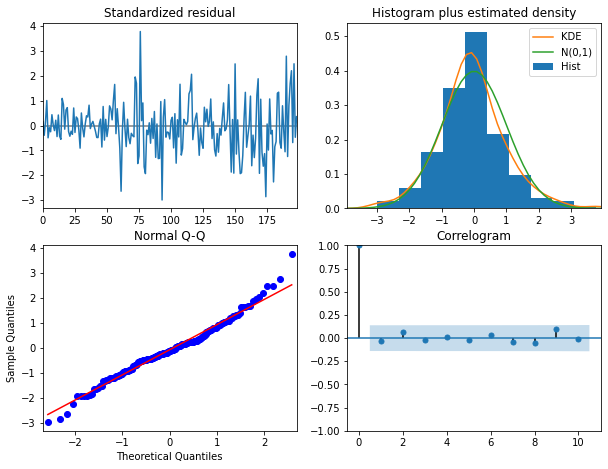

In [ ]:
res.plot_diagnostics();

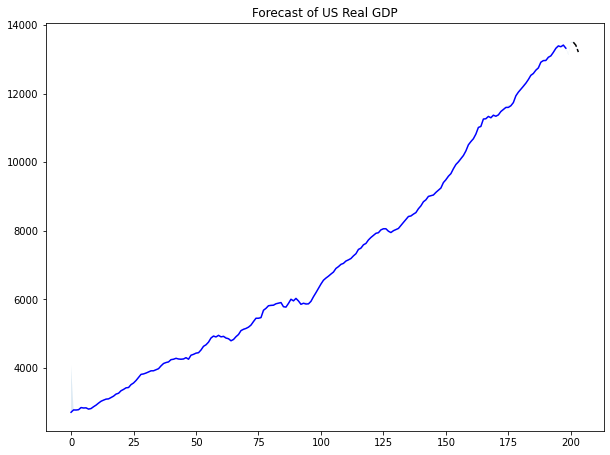

In [ ]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                             exog=exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'][:199], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

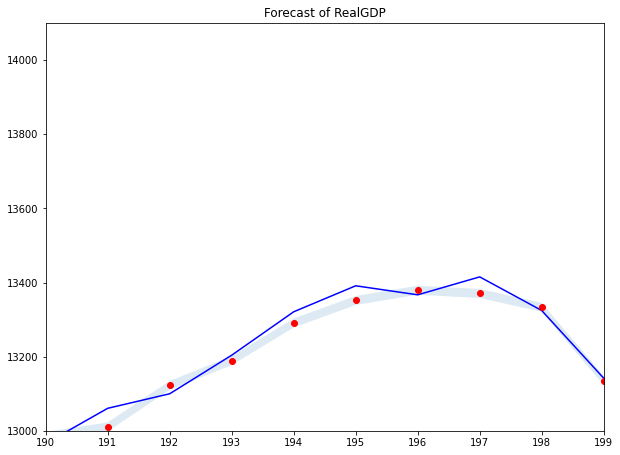

In [ ]:
fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_xlim(190,199)
ax.set_ylim(13000, 14100)

ax.set_title('Forecast of RealGDP')
plt.show()

In [ ]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])

print(f'MSE : {mse}')

MSE : 6924.650888668192


In [ ]:
mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data['realgdp']))

print(f'MAPE : {round(mape * 100, 2)}%')

MAPE : 0.39%


### General Modeling Procedure
- Plot data and identify unusual observations. Find the pattern in the data.  
(데이터를 시각화하고 비정상적인 관측치를 식별한다. 데이터에서 패턴을 찾는다.)
- Apply a transformation or differencing to remove trend and stabilize variance.  
(변환 또는 차분을 적용하여 추세를 제거하고 분산을 안정화합니다.)
- Test for stationarity. If not stationary, apply another transformation or differencing.  
(정상성을 테스트한다. 데이터가 정상성을 띄지 않는 경우, 변환 또는 차분을 적용한다.)
- Plot ACF and PACF to maybe estimate the order of MA or AR process.  
(ACF 및 PACF를 그려서 MA 또는 AR의 order를 정한다.)
- Try different combinations of orders and select the model with the lower AIC.  
(다양한 order 조합을 시도하여 AIC가 낮은 모델을 선택합니다.)
- Check the residuals and make sure that they look like white noise. Apply the Ljung-Box Test.  
(잔차를 확인하고 White-noise 인지 확인한다. Ljung-Box 테스트를 적용한다.)
- Calculate forecasts.  
(예측값을 계산한다.)

VAR

In [7]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests

In [8]:
# United States Macroeconomic Dataset
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


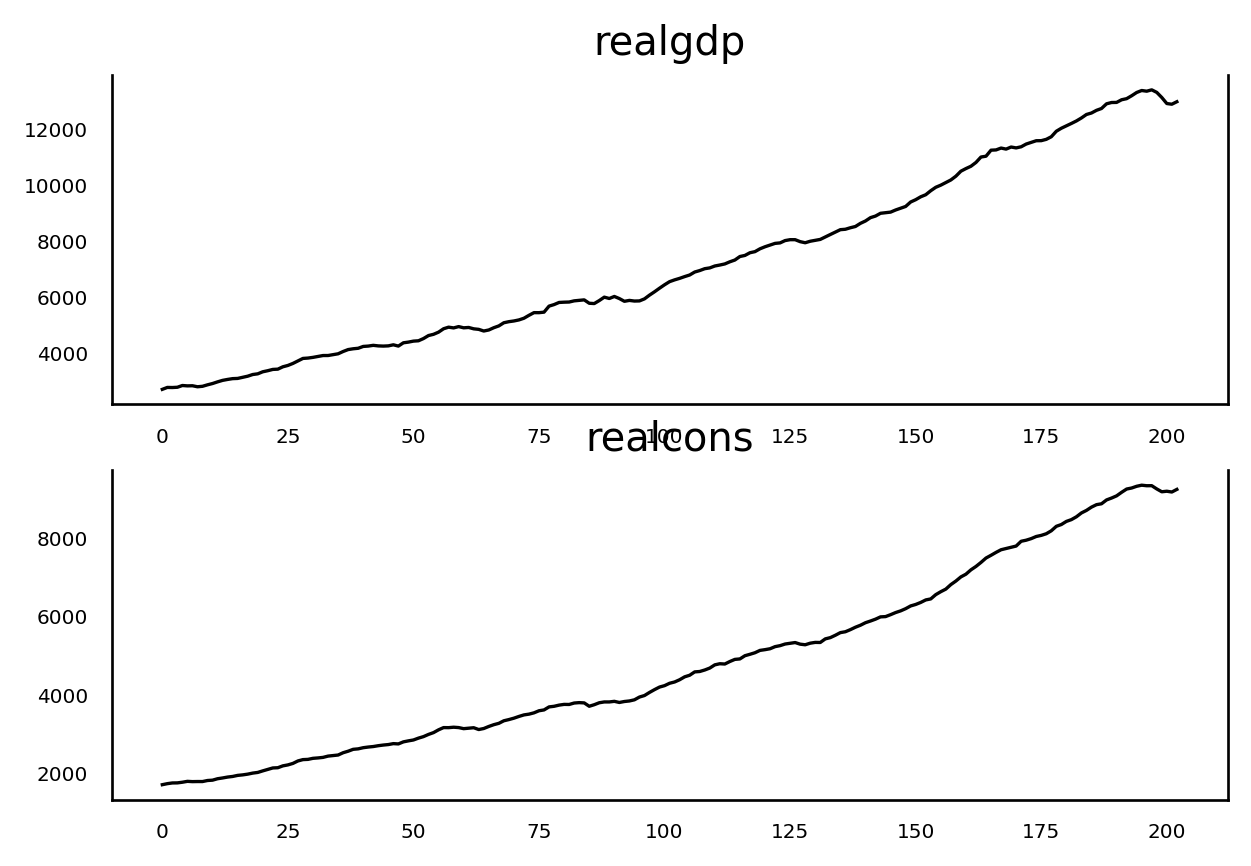

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

In [10]:
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print(f'Critical Values: ')
for key, value in ad_fuller_result_1[4].items():
    print(f'\t{key} {value:.3f}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08
Critical Values: 
	1% -3.463
	5% -2.876
	10% -2.575


In [11]:
ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
print(f'Critical Values: ')
for key, value in ad_fuller_result_2[4].items():
    print(f'\t{key} {value:.3f}')

ADF Statistic: -4.204306080845249
p-value: 0.0006479282158627514
Critical Values: 
	1% -3.464
	5% -2.876
	10% -2.575


In [12]:
def optimize_VAR(endog):
    '''
    Returns a dataframe with parameters and corresponding MSE
    
    endog - observed time series
    '''
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)
result_df

,p,mse
0,13,1.354899e+05
1,11,1.457493e+05
2,12,1.561347e+05
3,10,1.587974e+05
4,8,1.596335e+05
5,9,1.625314e+05
6,7,1.637843e+05
7,6,1.700904e+05
8,5,1.752926e+05
9,4,1.984334e+05


In [14]:
best_model = VARMAX(endog, order=(13, 0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(13)   Log Likelihood               -1978.615
                               + intercept   AIC                           4071.230
Date:                     Tue, 02 Feb 2021   BIC                           4260.083
Time:                             04:15:30   HQIC                          4147.632
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.03, 0.00   Jarque-Bera (JB):           4.89, 4.99
Prob(Q):                        0.86, 1.00   Prob(JB):                   0.09, 0.08
Heteroskedasticity (H):         1.73, 2.55   Skew:                       0.3

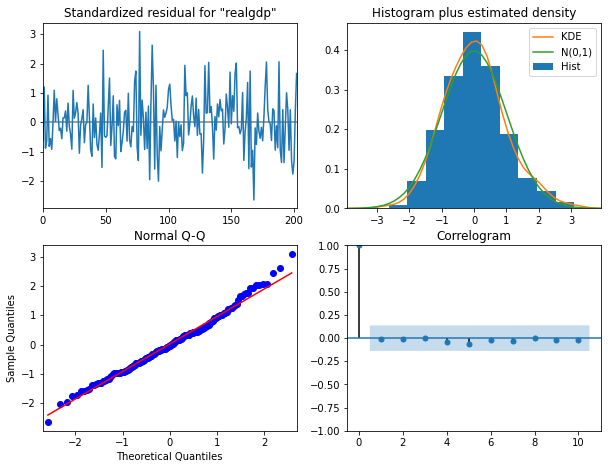

In [18]:
res.plot_diagnostics();

In [16]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,realgdp,realcons
204,13166.933674,9325.731193
205,13202.304434,9326.142736
206,13240.521792,9337.990458


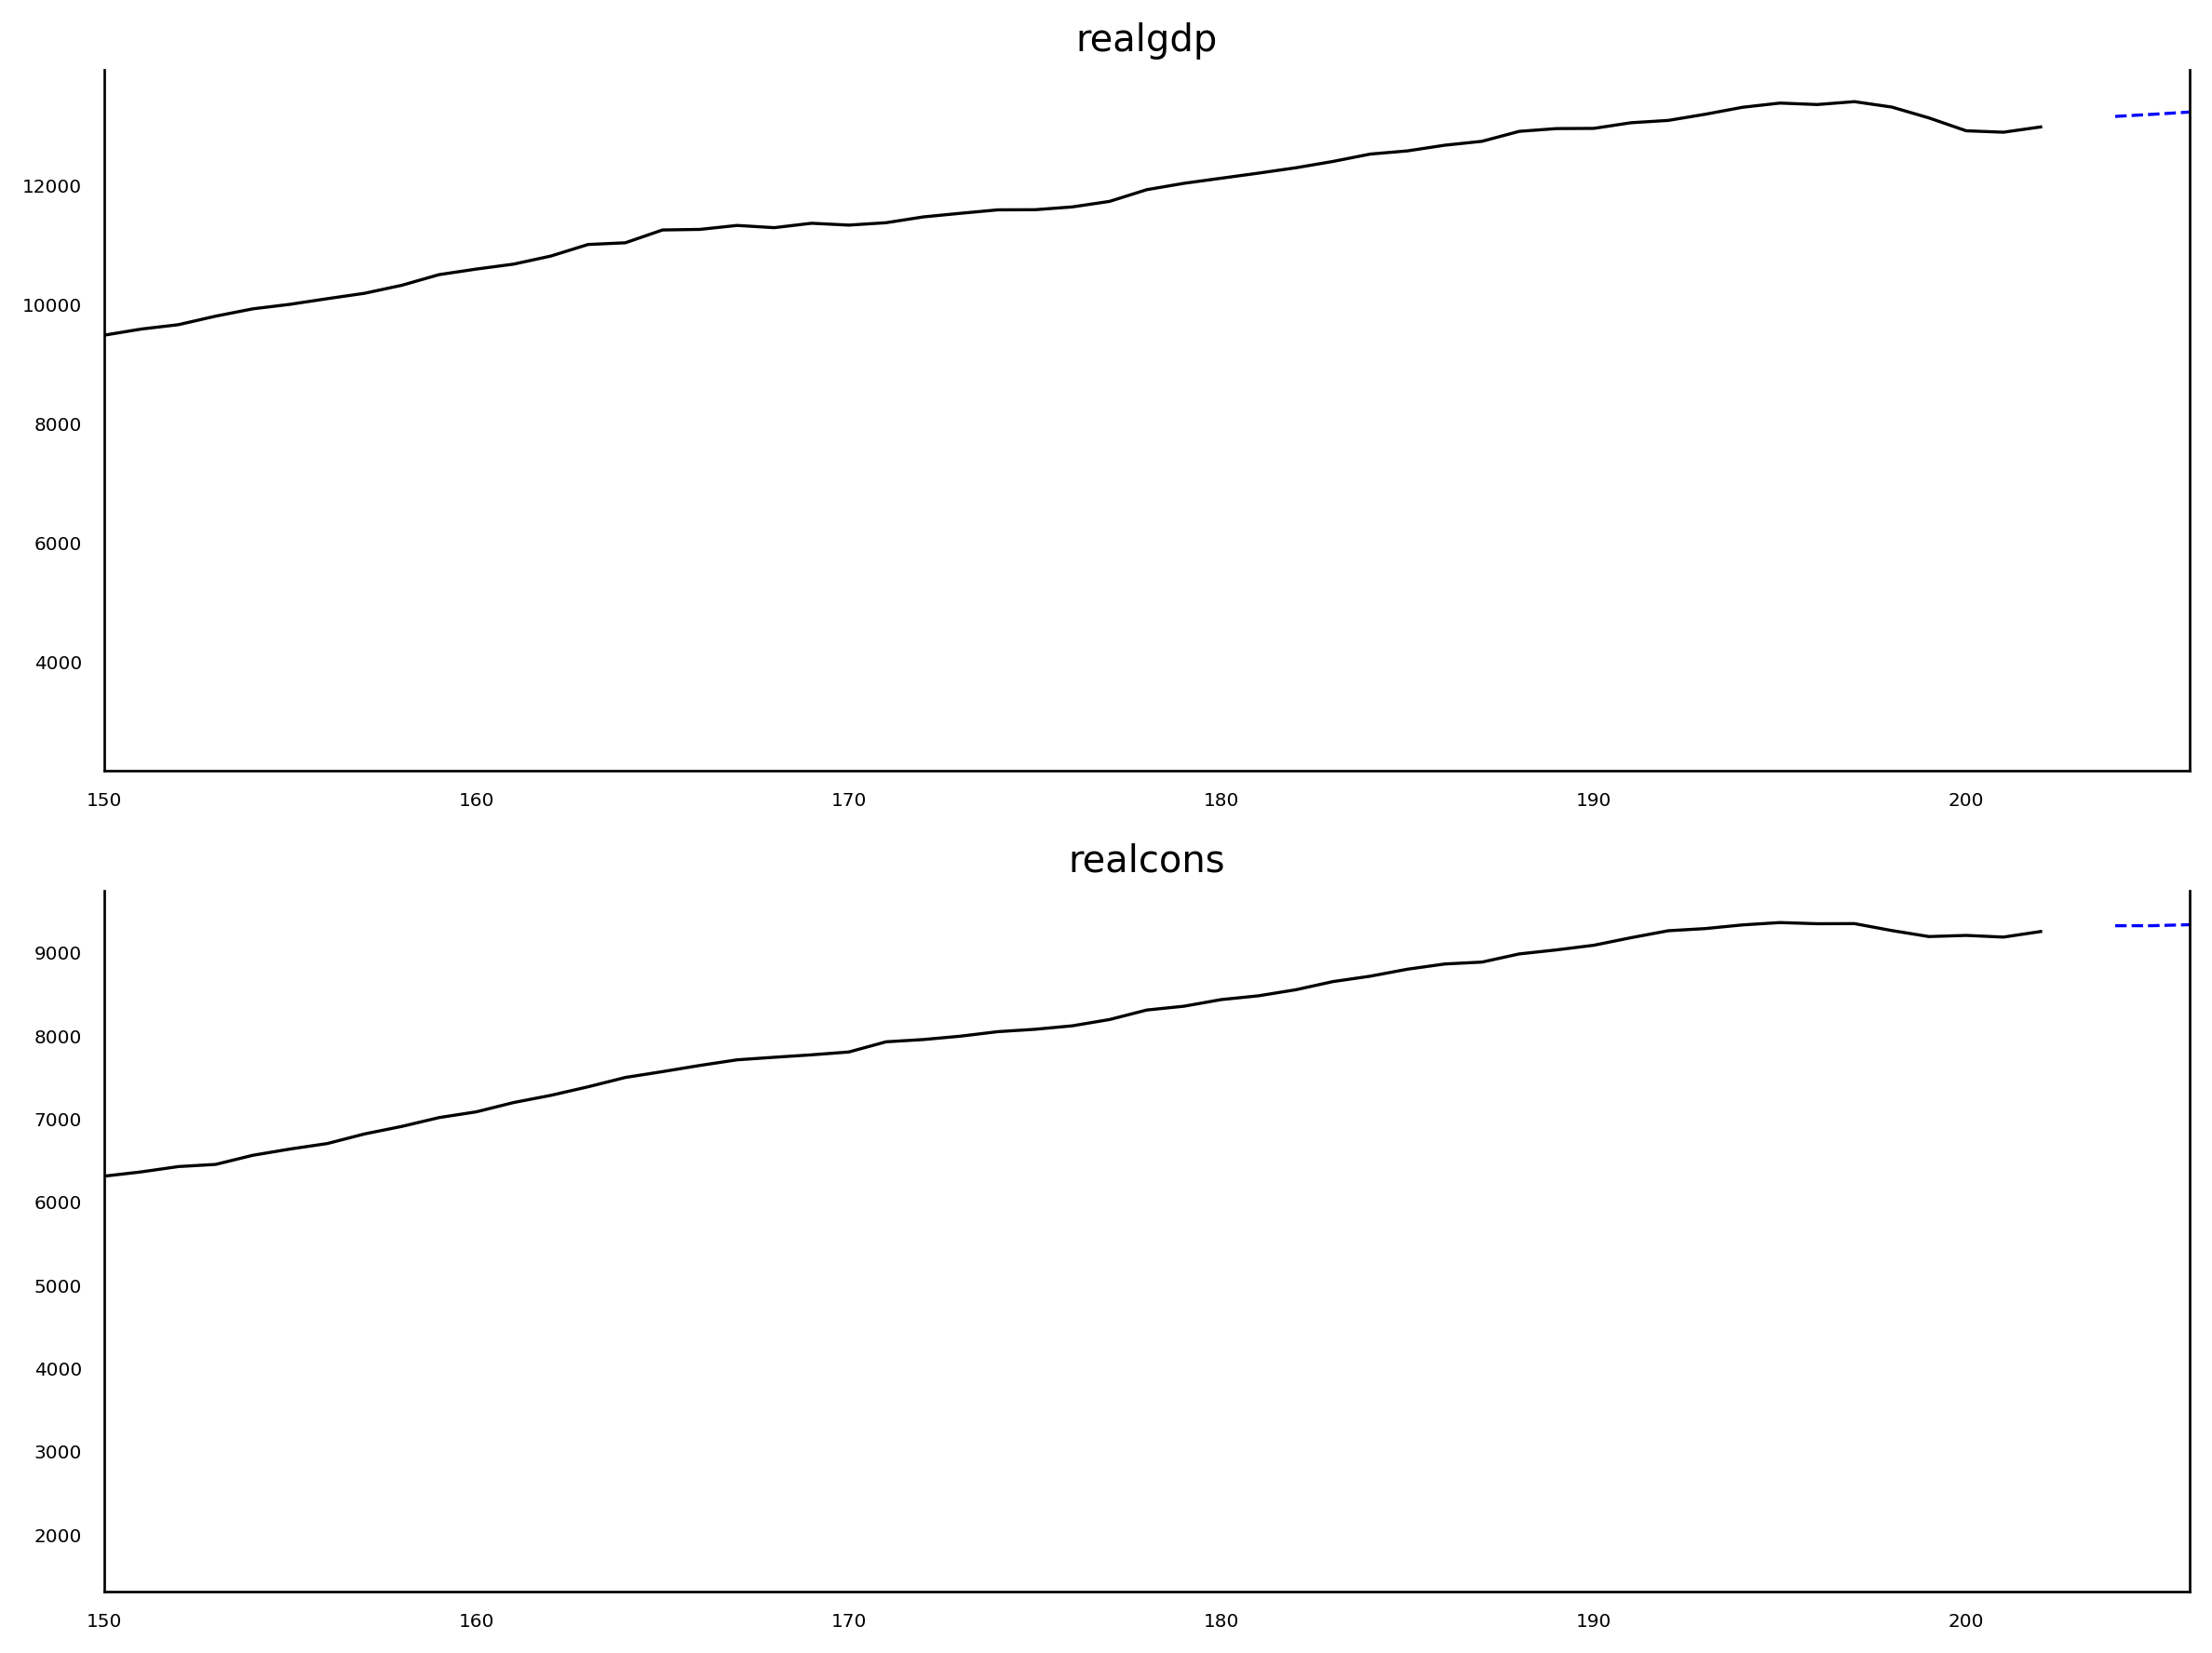

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], predict.predicted_mean['realgdp'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], predict.predicted_mean['realcons'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

In [22]:
print('realcons causes realgdp?\n')
print('---------------------------')
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [13])

print('\nrealgdp causes realcons?\n')
print('---------------------------')
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [13])


realcons causes realgdp?

---------------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=85.5708 , p=0.0000  , df=13
likelihood ratio test: chi2=70.5844 , p=0.0000  , df=13
parameter F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13

realgdp causes realcons?

---------------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=32.3973 , p=0.0021  , df=13
likelihood ratio test: chi2=29.9021 , p=0.0049  , df=13
parameter F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13


### Granger Causality
 두 개의 시계열 데이터에서 한 변수(한 시계열)의 과거데이터와 다른 한 변수(시계열)의 과거데이터의 결합으로 그 변수(처음 시계열)를 선형 예측(linear regression)을 했을 때 다른 한 변수의 과거 데이터로만 선형예측한 것이 통계적으로 유의미하게 영향력이 있다면 그것을 그레인저 인과(Granger Causality)가 있다고 한다.  
>단, 흔히 생각하는 인과(Causality)와는 다르다.
  
---
[예시]
- 닭과 달걀의 생산량의 인과관계
- 단기금리와 중기, 단기 금리와의 인과관계
- 강수량과 동물원방문객수의 인과관계
- 급여인상액과 소비금액의 인과관계
- 어떤 회사의 광고비지출액과 매출액의 인과관계
- 강수량과 인터넷사용량의 인과관계
- 어떤 광고캠페인의 수치형 설정조건과 클릭수와 인과관계

VARMA

In [23]:
def optimize_VARMA(endog, parameters_list):
    '''
    Returns a dataframe with parameters (p, q) and corresponding MSE

    endog - the observed variable
    parameters_list - list of (p, q) tuples
    '''

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([param, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'mse']

    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

In [27]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

,"(p, q)",mse
0,"(3, 1)",1.770722e+05
1,"(3, 2)",1.816619e+05
2,"(3, 3)",1.995401e+05
3,"(1, 1)",2.504636e+05
4,"(3, 0)",3.129511e+05
5,"(0, 1)",5.927073e+05
6,"(2, 1)",5.949300e+05
7,"(1, 2)",6.567416e+05
8,"(0, 3)",1.004195e+06
9,"(1, 3)",1.175110e+06


In [28]:
best_model_VARMA = VARMAX(endog, order=(3, 1))

res_VARMA = best_model_VARMA.fit(disp=False)
print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                          VARMA(3,1)   Log Likelihood               -2000.992
                               + intercept   AIC                           4043.983
Date:                     Tue, 02 Feb 2021   BIC                           4113.561
Time:                             05:17:12   HQIC                          4072.132
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.53, 0.02   Jarque-Bera (JB):          3.31, 10.48
Prob(Q):                        0.47, 0.88   Prob(JB):                   0.19, 0.01
Heteroskedasticity (H):         2.47, 2.97   Skew:                       0.1

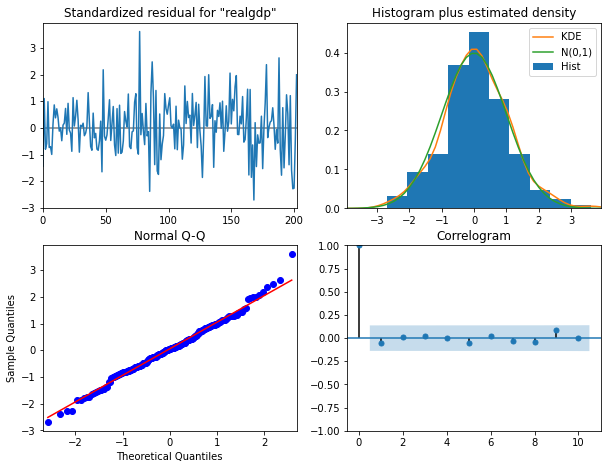

In [29]:
res_VARMA.plot_diagnostics();

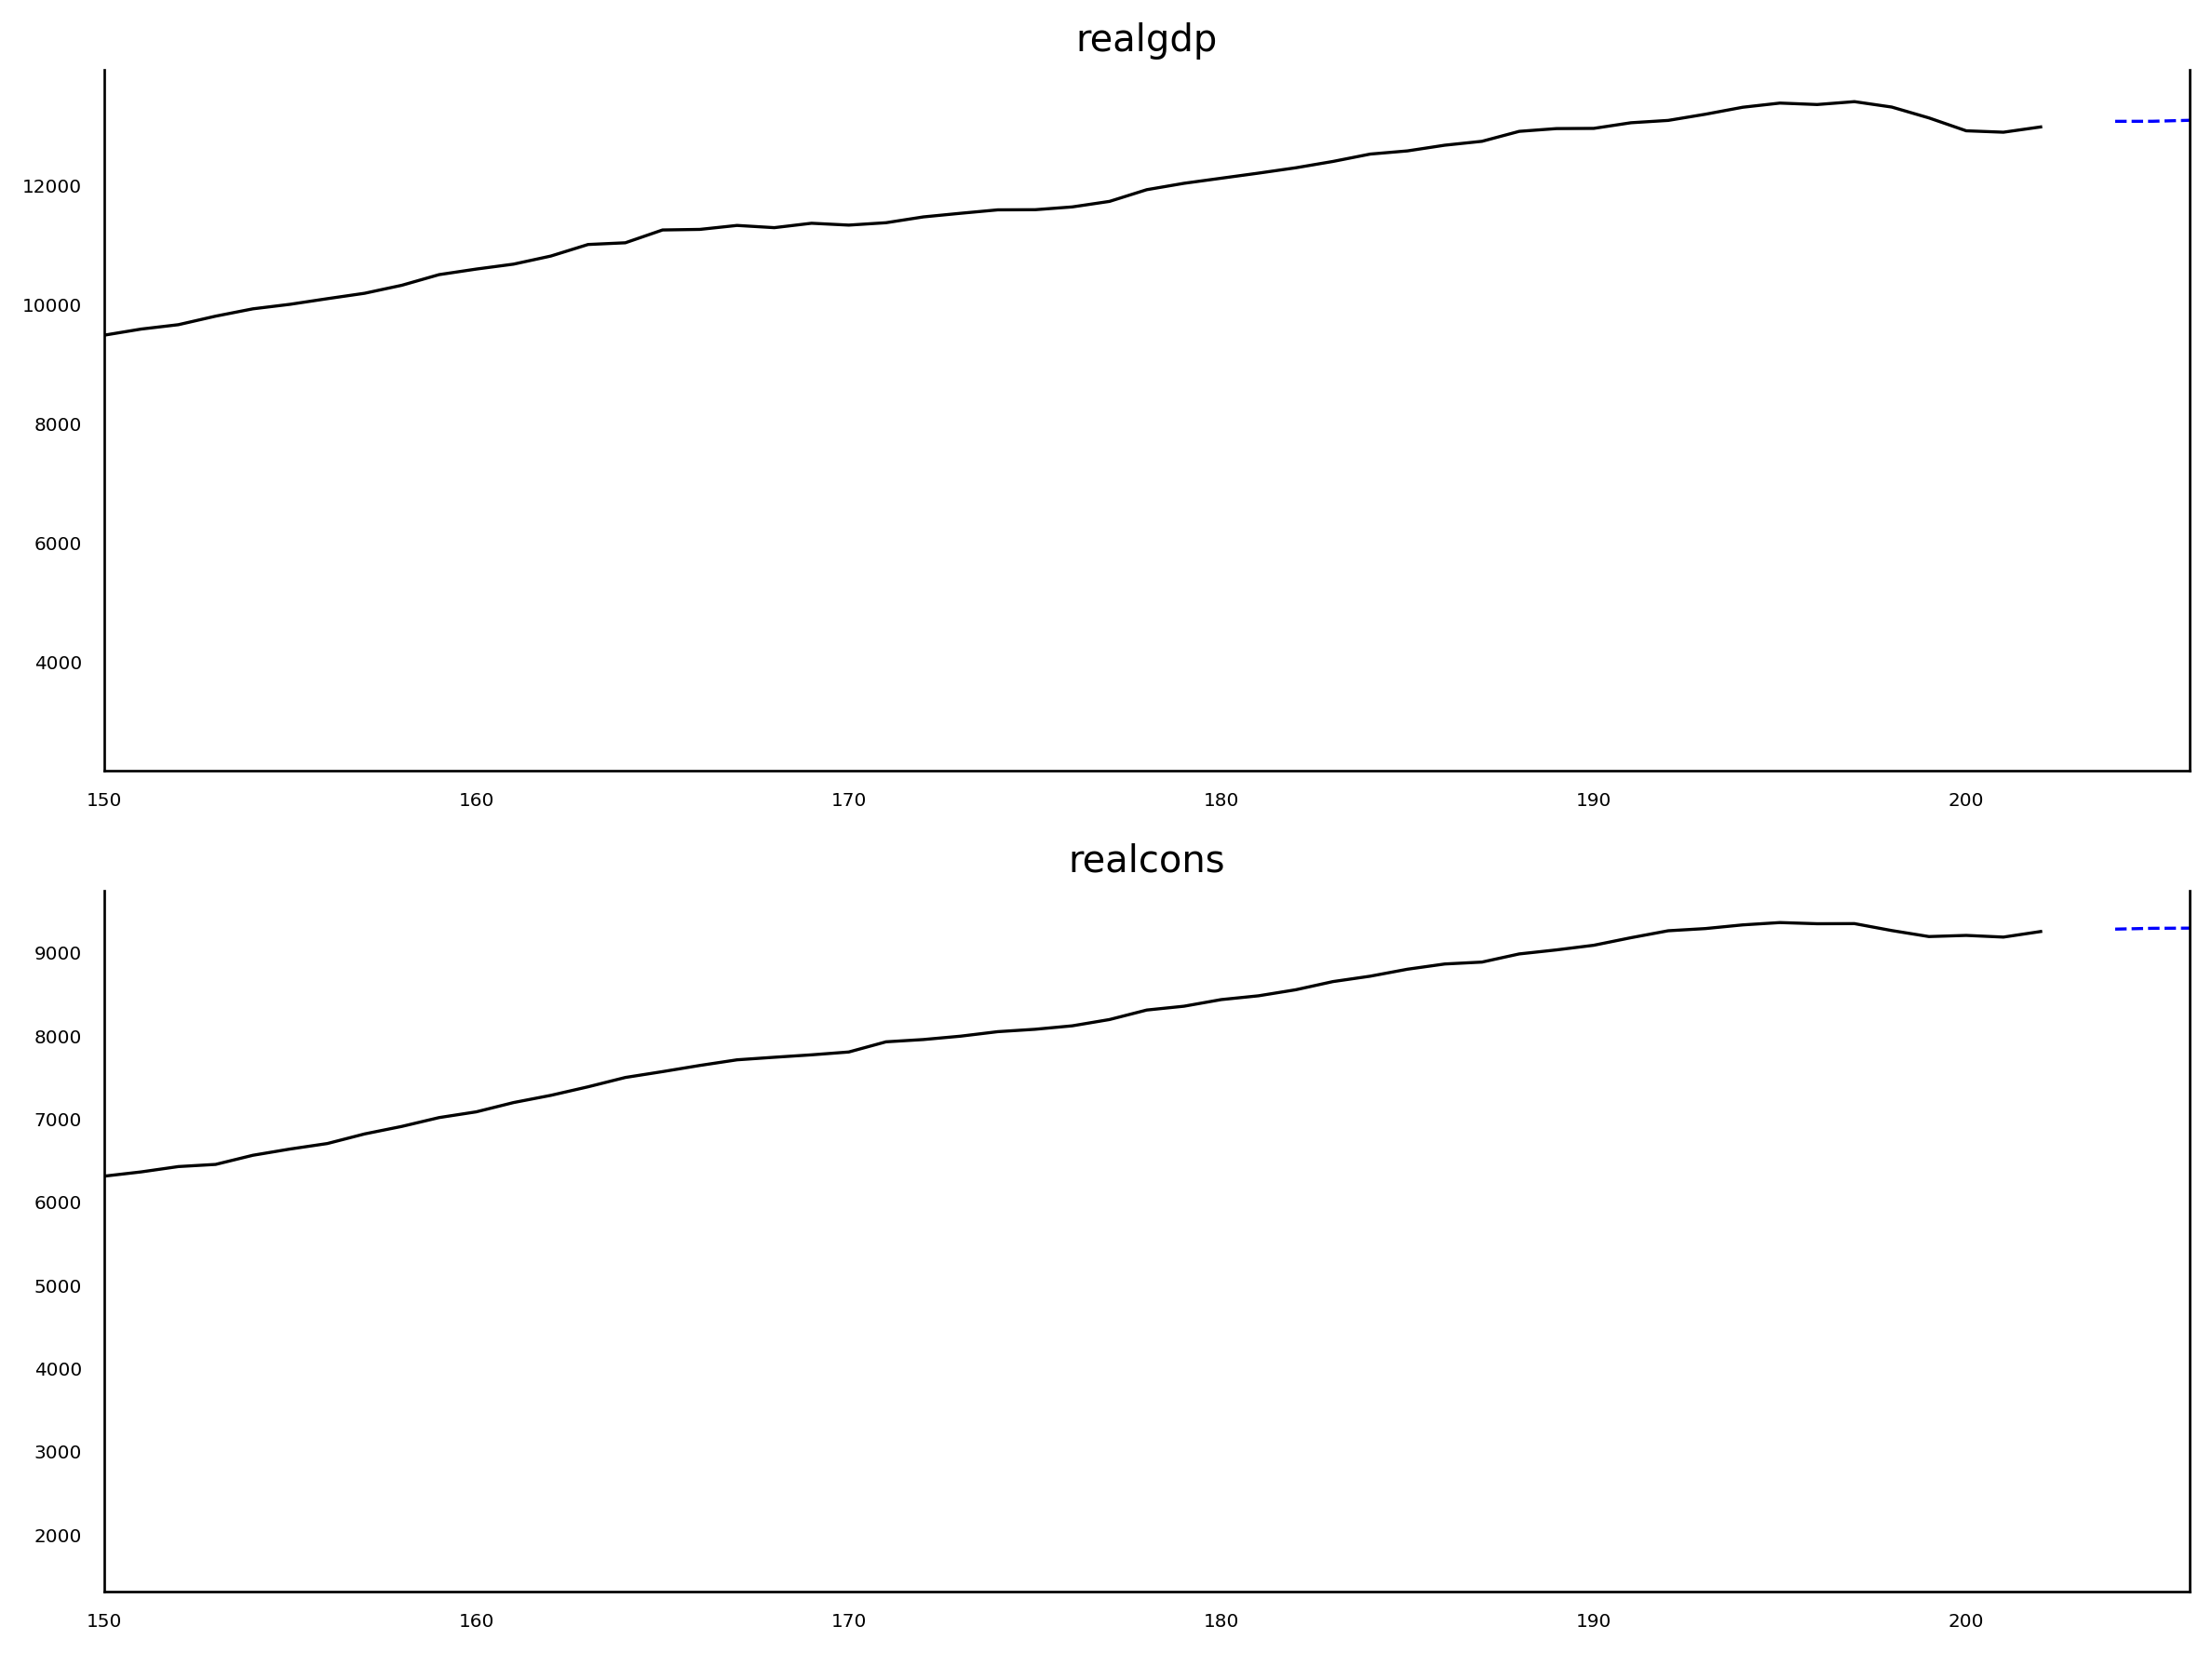

In [31]:
n_forecast = 3

predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:],
         predict.predicted_mean['realgdp'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:],
         predict.predicted_mean['realcons'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

VARMAX

In [32]:
def optimize_VARMAX(endog, exog, parameters_list):
    '''
    Returns  a dataframe with (p, q) and MSE

    endog - the observed variables
    exog - the exogenous variables
    parameters_list - list of (p, q) tuples
    '''

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([param, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'mse']

    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

In [33]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year','quarter','realgdp','realcons'])
exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)
result_df_VARMAX

,"(p, q)",mse
0,"(1, 3)",2317.233688
1,"(3, 3)",2326.988072
2,"(2, 3)",2342.571808
3,"(3, 2)",2364.362966
4,"(2, 2)",2396.943452
5,"(1, 2)",2431.296781
6,"(3, 1)",2465.099057
7,"(3, 0)",2519.680691
8,"(2, 1)",2542.495214
9,"(1, 0)",2559.286604


In [36]:
best_model_VARMAX = VARMAX(endog, exog, order=(1, 3))
res_VARMAX = best_model_VARMAX.fit(disp=False)
print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(1,3)   Log Likelihood               -1949.914
                               + intercept   AIC                           3981.827
Date:                     Tue, 02 Feb 2021   BIC                           4117.058
Time:                             05:36:23   HQIC                          4036.553
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             3.11, 0.20   Jarque-Bera (JB):           7.00, 2.85
Prob(Q):                        0.08, 0.66   Prob(JB):                   0.03, 0.24
Heteroskedasticity (H):         1.59, 2.50   Skew:                       0.1

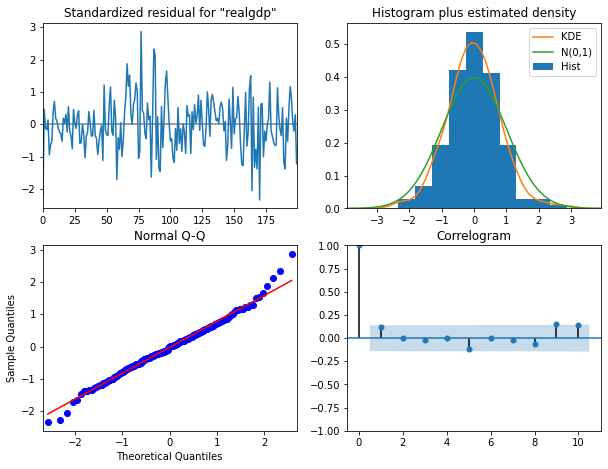

In [37]:
res_VARMAX.plot_diagnostics();

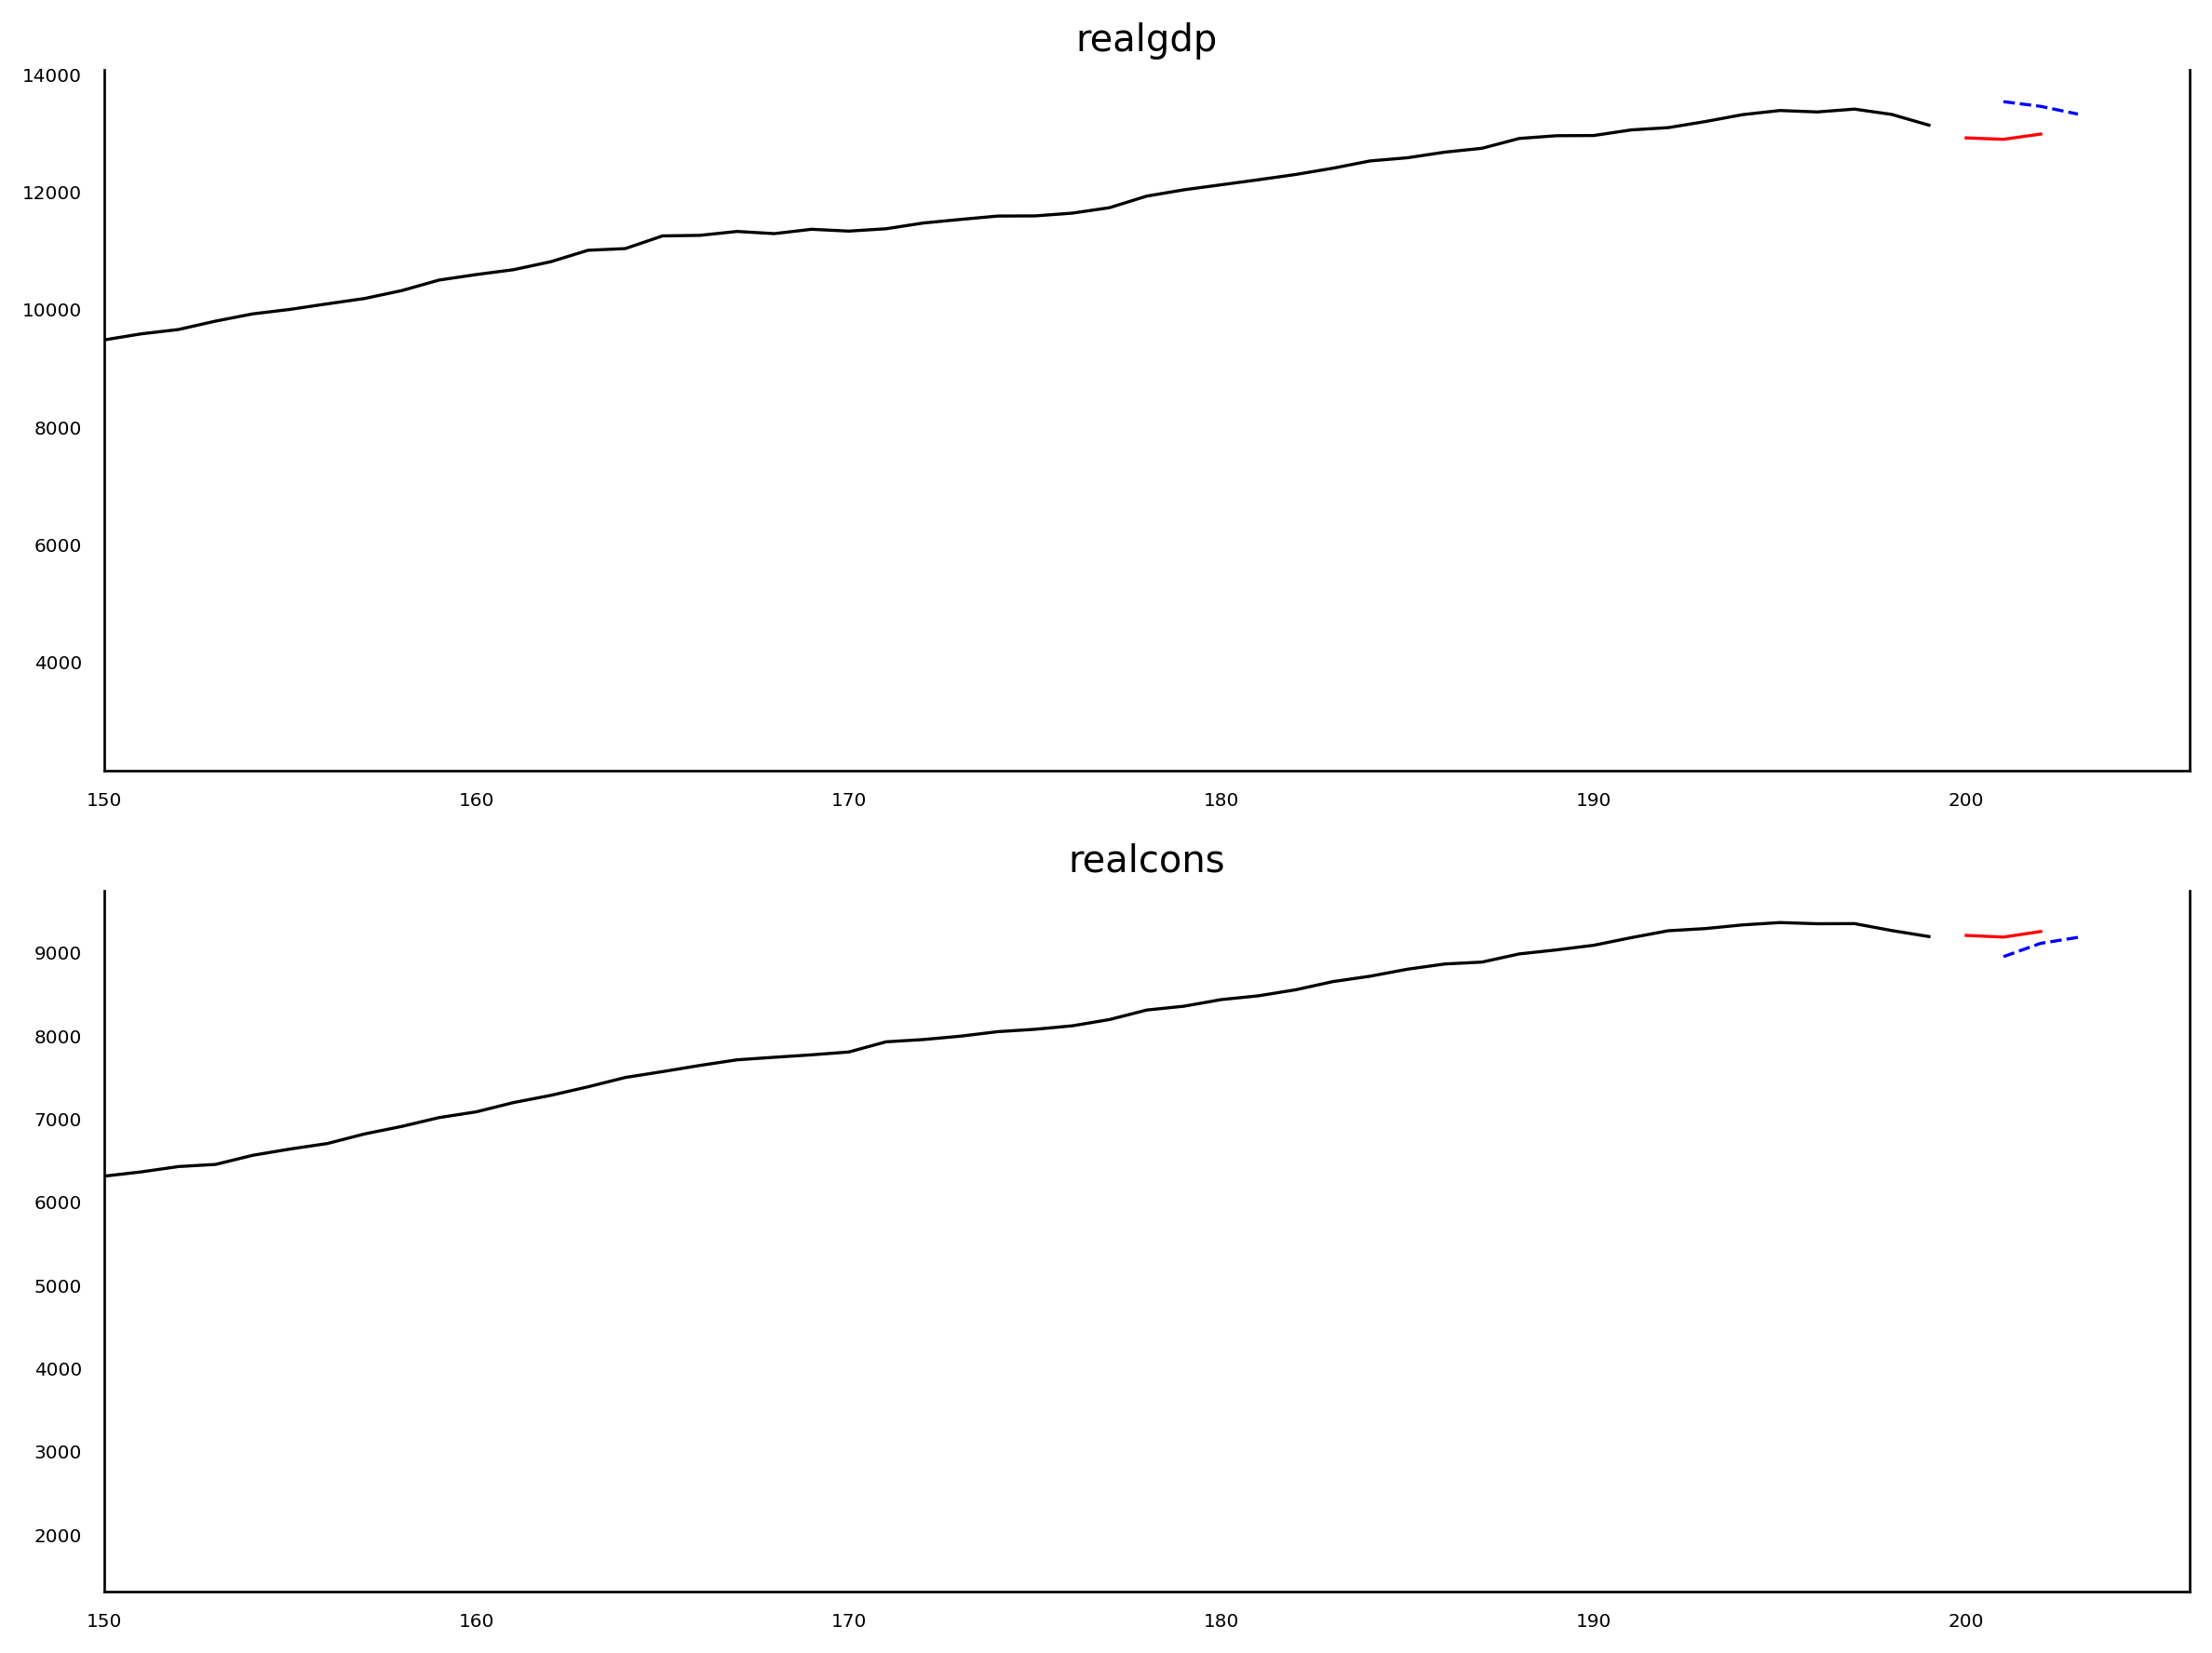

In [38]:
n_forecast = 3
predict = res_VARMAX.get_prediction(
    end=best_model_VARMAX.nobs + n_forecast,
    exog = exog.iloc[-4:]
)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'][:200], color='black', linewidth=1)
ax1.plot(macro_data['realgdp'][200:], color='red', linewidth=1)
ax1.plot(idx[-n_forecast:],
         predict.predicted_mean['realgdp'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1
         )
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'][:200], color='black', linewidth=1)
ax2.plot(macro_data['realcons'][200:], color='red', linewidth=1)
ax2.plot(idx[-n_forecast:],
         predict.predicted_mean['realcons'][-n_forecast:],
         color='blue',
         ls='--',
         linewidth=1
         )
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()
plt.show()